### Compare XGBoost on raw versus embedded data

This experiment aims to show that the embedded data works better for predictions than the raw data

In [3]:
from keras.models import Sequential
from sklearn import metrics
import xgboost as xgb
import numpy as np
import pickle, os

from model import mnist_cnn2, get_acc, bootstrap_test
from deepshap.data import load_mnist

# multiclass classification using the softmax objective
XGB_PARAM = {
    'max_depth': 5, 'eta': 0.5, 'eta_decay': 0.9, 'min_eta': 0.05,
    'silent': 0, 'objective': 'multi:softmax',   
    'num_class': 10,'early_stopping_rounds': 10
}

# Load data
x_train, y_train, x_test, y_test = load_mnist()

# Reshape x
x_train_flat = x_train.reshape([x_train.shape[0],784])
x_test_flat  = x_test.reshape([x_test.shape[0],784])

### Get embedded data ###
cnn_mod = mnist_cnn2() # Load the CNN
emb_mod = Sequential() # Exclude last layer
for layer in cnn_mod.layers[:-1]: emb_mod.add(layer)
x_train_embe = emb_mod.predict(x_train)
x_test_embe  = emb_mod.predict(x_test)

xgb_acc_lst     = []; cnn_xgb_acc_lst = []
num_trees_lst   = [5,10,30,50,100,200]

if not os.path.exists("results/cnn_xgb_acc_arr.npy"):

    for num_trees in num_trees_lst:
        print("\nNumber of estimators: {}".format(num_trees)+"\n"+"#"*20)

        ### XGB ###
        print("\nXGB"+"\n"+"#"*10)
        # Train model
        flat_train_data = xgb.DMatrix(x_train_flat, label=y_train)
        xgb_model_raw = xgb.train(XGB_PARAM, flat_train_data, num_trees)
        
        # Get accuracies
        train_accu = get_acc(xgb_model_raw, xgb.DMatrix(x_train_flat), y_train)
        test_accu  = get_acc(xgb_model_raw, xgb.DMatrix(x_test_flat), y_test)
        print("Train Accuracy:", train_accu); print("Test Accuracy: ", test_accu)
        test_pred = xgb_model_raw.predict(xgb.DMatrix(x_test_flat))
        xgb_acc_lst.append(bootstrap_test(y_test, test_pred))

        ### CNN->XGB ###
        print("\nCNN->XGB"+"\n"+"#"*10)
        # Train XGB model
        emb_train_data = xgb.DMatrix(x_train_embe, label=y_train)
        xgb_model_emb = xgb.train(XGB_PARAM, emb_train_data, num_trees)

        # Evaluate the accuracies
        train_accu = get_acc(xgb_model_emb, xgb.DMatrix(x_train_embe), y_train)
        test_accu  = get_acc(xgb_model_emb, xgb.DMatrix(x_test_embe), y_test)
        print("Train Accuracy:", train_accu); print("Test Accuracy: ", test_accu)
        test_pred = xgb_model_emb.predict(xgb.DMatrix(x_test_embe))
        cnn_xgb_acc_lst.append(bootstrap_test(y_test, test_pred))

    xgb_acc_arr     = np.array(xgb_acc_lst)
    cnn_xgb_acc_arr = np.array(cnn_xgb_acc_lst)
    
    np.save("results/xgb_acc_arr.npy",     xgb_acc_arr)
    np.save("results/cnn_xgb_acc_arr.npy", cnn_xgb_acc_arr)
    
else:
    xgb_acc_arr     = np.load("results/xgb_acc_arr.npy")
    cnn_xgb_acc_arr = np.load("results/cnn_xgb_acc_arr.npy")

Test loss: 0.0424361377954483
Test accuracy: 0.9865999817848206


In [4]:
from keras.models import Sequential
from sklearn import metrics
import xgboost as xgb
import numpy as np
import pickle, os

from model import mnist_cnn2, get_acc, bootstrap_test
from deepshap.data import load_mnist

# multiclass classification using the softmax objective
XGB_PARAM = {
    'max_depth': 5, 'eta': 0.5, 'eta_decay': 0.9, 'min_eta': 0.05,
    'silent': 0, 'objective': 'multi:softmax',   
    'num_class': 10,'early_stopping_rounds': 10
}

# Load data
x_train, y_train, x_test, y_test = load_mnist()


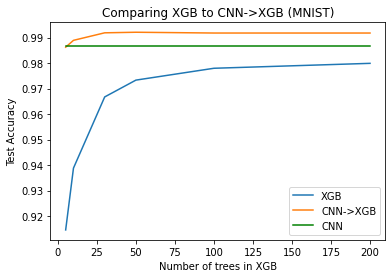

In [12]:
import matplotlib.pyplot as plt
from scipy.stats import sem

# Plot accuracies
plt.plot(num_trees_lst, xgb_acc_arr.mean(1), 
             label="XGB")

plt.plot(num_trees_lst, cnn_xgb_acc_arr.mean(1), 
             label="CNN->XGB")

plt.plot([num_trees_lst[0],num_trees_lst[-1]], [0.9866,0.9866], 
         label="CNN", color="g")

plt.title("Comparing XGB to CNN->XGB (MNIST)")
plt.ylabel("Test Accuracy")
plt.xlabel("Number of trees in XGB")
plt.legend()
plt.savefig("fig/compare_xgb_to_cnn.pdf")
plt.show()